In [1]:
import numpy as np
import gymnasium as gym
from matplotlib import pyplot as plt
import seaborn as sns
import random
from tqdm.notebook import tqdm
import os
import pandas as pd
import sys
import wandb
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# Training parameters
n_training_episodes = 1000 # Total training episodes
# Evaluation parameters
n_eval_episodes = 100 # Total number of test episodes
# Environment parameters
env_id = "Taxi-v3" # Name of the environment
max_steps = 99 # Max steps per episode
# Exploration parameterss
min_epsilon = 0.05
max_epsilon = 1.0
decay_rate = 0.005 # Exponential decay rate for exploration prob

In [3]:
learning_rates = [0.01, 0.1, 1]
gammas = [0.1, 0.6, 0.9]

In [4]:
DOWN = 0
UP = 1
RIGHT = 2
LEFT = 3
PICKUP = 4
DROP = 5
epochs = 0

In [5]:
run = wandb.init(project="Taxi-Q-learning-training", entity="picsou")
env = gym.make("Taxi-v3", render_mode="ansi")
q_table = np.zeros([env.observation_space.n, env.action_space.n])


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: picsou. Use `wandb login --relogin` to force relogin


In [ ]:
def Train (learning_rate, gamma):
    # Using Q-learning to train via reinforcement
    run = wandb.init(project="Taxi-Q-learning-Evaluate", entity="picsou")
    timesteps = []
    for i in range(1, 10000):
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(decay_rate * i)
        state = env.reset()[0]

        epochs, penalties, reward, episode_reward = 0, 0, 0, 0
        episode_action = [0, 0, 0, 0, 0, 0]
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Explore action space
            else:
                action = np.argmax(q_table[state])  # Exploit learned values

            episode_action[action] += 1
            next_state, reward, done, info, _ = env.step(action)
            episode_reward += reward

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])
            #new_value =  old_value + learning_rate * (reward + gamma + next_max - old_value)
            new_value = (1 - learning_rate) * old_value + learning_rate * (reward + gamma * next_max)
            q_table[state, action] = new_value

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1

        wandb.log({"reward": episode_reward, "duration": epochs,
                "penalties": penalties,
                "down": episode_action[DOWN],
                "up": episode_action[UP],
                "right": episode_action[RIGHT],
                "left": episode_action[LEFT],
                "Pickup": episode_action[PICKUP],
                "Drop": episode_action[DROP]})
        epochs += 1
        timesteps.append(epochs)
    run.finish()
    return timesteps

In [ ]:
results = pd.DataFrame()
for learning_rate in learning_rates:
    for gamma in gammas:
        print(f'learning_rate: {learning_rate}, gamma: {gamma}')
        timesteps = Train(n_training_episodes, False)
        results_ = pd.DataFrame()
        results_['timesteps'] = timesteps
        results_['learning_rate'] = learning_rate
        results_['gamma'] = gamma
        print(results_)
        print(results)
        results = pd.concat([results, results_])

results = results.reset_index().rename(columns={'index': 'episode'})
results['hyperparameters'] = [f'learning_rate={lr}, gamma={g}'
                              for (lr, g) in zip(results['learning_rate'], results['gamma'])
]

learning_rate: 0.01, gamma: 0.1


/var/folders/th/ll09csqn7pz00r6xjklmvw0m0000gn/T/ipykernel_36530/1635588312.py:25: RuntimeWarning: overflow encountered in scalar multiply
  new_value =  old_value + learning_rate * (reward + gamma + next_max - old_value)
/var/folders/th/ll09csqn7pz00r6xjklmvw0m0000gn/T/ipykernel_36530/1635588312.py:25: RuntimeWarning: invalid value encountered in scalar subtract
  new_value =  old_value + learning_rate * (reward + gamma + next_max - old_value)
/var/folders/th/ll09csqn7pz00r6xjklmvw0m0000gn/T/ipykernel_36530/1635588312.py:25: RuntimeWarning: invalid value encountered in scalar add
  new_value =  old_value + learning_rate * (reward + gamma + next_max - old_value)


KeyboardInterrupt: 

       episode  timesteps  learning_rate  gamma                hyperparameters
0            0         99           0.01    0.1  learning_rate=0.01, gamma=0.1
1            1         99           0.01    0.1  learning_rate=0.01, gamma=0.1
2            2         99           0.01    0.1  learning_rate=0.01, gamma=0.1
3            3         99           0.01    0.1  learning_rate=0.01, gamma=0.1
4            4         62           0.01    0.1  learning_rate=0.01, gamma=0.1
...        ...        ...            ...    ...                            ...
89986     9994         99           1.00    0.9   learning_rate=1.0, gamma=0.9
89987     9995         99           1.00    0.9   learning_rate=1.0, gamma=0.9
89988     9996         99           1.00    0.9   learning_rate=1.0, gamma=0.9
89989     9997         99           1.00    0.9   learning_rate=1.0, gamma=0.9
89990     9998         99           1.00    0.9   learning_rate=1.0, gamma=0.9

[89991 rows x 5 columns]


<Axes: xlabel='episode', ylabel='timesteps'>

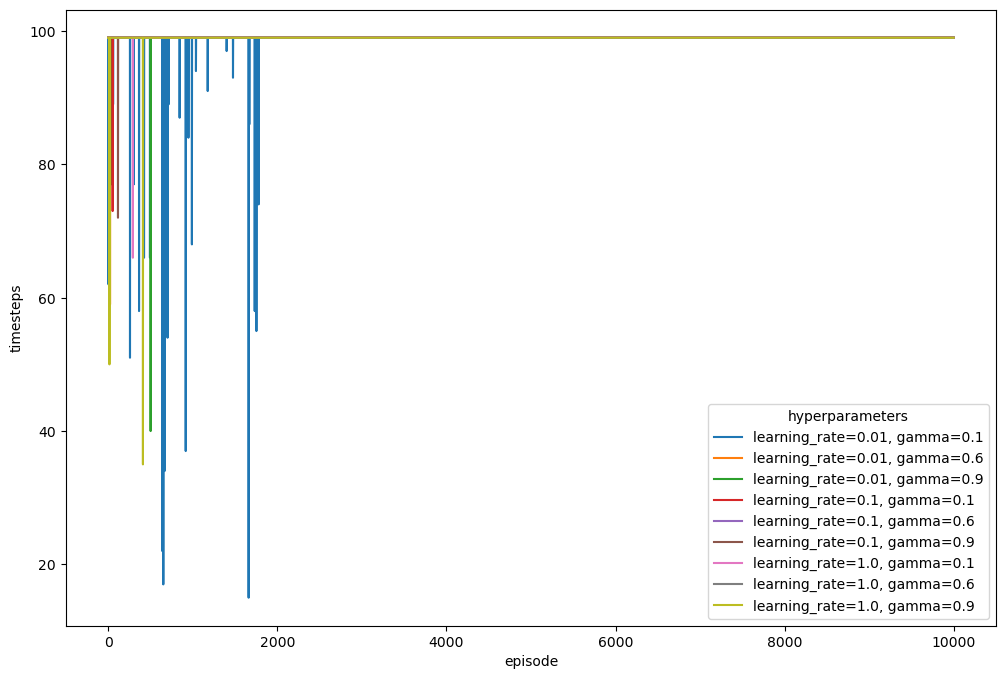

In [ ]:
fig = plt.gcf()
print(results)
fig.set_size_inches(12, 8)
sns.lineplot(x='episode', y='timesteps', hue='hyperparameters', data=results)